<a href="https://colab.research.google.com/github/shouryasinghchouhan2/Mytest/blob/master/Used_Car_price_prediction_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Car Price Prediction with PySpark
## data-info: Used cars in United States for sale


# 1. Installation

In [1]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 2. Import Necessary Modules

In [2]:
import json

import matplotlib.pyplot as plt
import seaborn as sns

import pyspark

from pyspark.sql import SparkSession
from pyspark.sql import types
from pyspark.sql import functions as F

from pyspark.ml.feature import Imputer, VectorAssembler, StringIndexer
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import FMRegressor
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# 3. Create a Spark Session

In [3]:
spark = SparkSession.builder.appName('Tutorial').getOrCreate()

# 4. Let's read the file

In [4]:
file_path = 'vehicles.csv'

df_cars = spark.read.options(header=True, inferSchema=True, delimiter=',', multiLine=True).csv(file_path)

# 5. Let's print the schema

In [5]:
df_cars.printSchema()

root
 |-- id: long (nullable = true)
 |-- url: string (nullable = true)
 |-- region: string (nullable = true)
 |-- region_url: string (nullable = true)
 |-- price: long (nullable = true)
 |-- year: integer (nullable = true)
 |-- manufacturer: string (nullable = true)
 |-- model: string (nullable = true)
 |-- condition: string (nullable = true)
 |-- cylinders: string (nullable = true)
 |-- fuel: string (nullable = true)
 |-- odometer: integer (nullable = true)
 |-- title_status: string (nullable = true)
 |-- transmission: string (nullable = true)
 |-- VIN: string (nullable = true)
 |-- drive: string (nullable = true)
 |-- size: string (nullable = true)
 |-- type: string (nullable = true)
 |-- paint_color: string (nullable = true)
 |-- image_url: string (nullable = true)
 |-- description: string (nullable = true)
 |-- county: string (nullable = true)
 |-- state: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- long: string (nullable = true)
 |-- posting_date: string (null

# 6. Data Cleaning



In [6]:
# these columns are useless to us, drop them

drop_cols = ['url', 'region_url', 'image_url', 'description']

df_cars = df_cars.drop(*drop_cols)

In [7]:
# both null values and null indicators(other) exist, set the indicator to null (to prevent confusion)

df_cars = df_cars.replace('other', None, subset=['cylinders'])

In [8]:
# both null values and null indicators(missing) exist, set the indicator to null (to prevent confusion)

df_cars = df_cars.replace('missing', None, subset=['title_status'])

In [9]:
# Latitude should be between (-90, 90), otherwise set null

df_cars = df_cars.withColumn('lat', F.when(F.col('lat').rlike('^-?\d+\.?\d+$'), F.col('lat')))
df_cars = df_cars.withColumn('lat', F.col('lat').cast(types.FloatType()))
df_cars = df_cars.withColumn('lat', F.when((-90 <= F.col('lat')) & (F.col('lat') <= 90), F.col('lat')))

In [10]:
# Longitude should be between (-180, 180), otherwise set null

df_cars = df_cars.withColumn('long', F.when(F.col('long').rlike('^-?\d+\.?\d+$'), F.col('long')))
df_cars = df_cars.withColumn('long', F.col('long').cast(types.FloatType()))
df_cars = df_cars.withColumn('long', F.when((-180 <= F.col('long')) & (F.col('long') <= 180), F.col('long')))

In [11]:
# Posting date should be in format yyyy-MM-dd HH:mm:ss.SSSS

df_cars = df_cars.withColumn('posting_date', F.when(F.col('posting_date').rlike('^\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2}-\d{4}$'), F.col('posting_date')))
df_cars = df_cars.withColumn('posting_date', F.col('posting_date').cast(types.TimestampType()))

In [12]:
df_cars.printSchema()

root
 |-- id: long (nullable = true)
 |-- region: string (nullable = true)
 |-- price: long (nullable = true)
 |-- year: integer (nullable = true)
 |-- manufacturer: string (nullable = true)
 |-- model: string (nullable = true)
 |-- condition: string (nullable = true)
 |-- cylinders: string (nullable = true)
 |-- fuel: string (nullable = true)
 |-- odometer: integer (nullable = true)
 |-- title_status: string (nullable = true)
 |-- transmission: string (nullable = true)
 |-- VIN: string (nullable = true)
 |-- drive: string (nullable = true)
 |-- size: string (nullable = true)
 |-- type: string (nullable = true)
 |-- paint_color: string (nullable = true)
 |-- county: string (nullable = true)
 |-- state: string (nullable = true)
 |-- lat: float (nullable = true)
 |-- long: float (nullable = true)
 |-- posting_date: timestamp (nullable = true)



In [13]:
df_cars.toPandas()

id                  region  price    year manufacturer  \
0       7222695916                prescott   6000     NaN         None   
1       7218891961            fayetteville  11900     NaN         None   
2       7221797935            florida keys  21000     NaN         None   
3       7222270760  worcester / central MA   1500     NaN         None   
4       7210384030              greensboro   4900     NaN         None   
...            ...                     ...    ...     ...          ...   
426577  7301591192                 wyoming  23590  2019.0       nissan   
426578  7301591187                 wyoming  30590  2020.0        volvo   
426579  7301591147                 wyoming  34990  2020.0     cadillac   
426580  7301591140                 wyoming  28990  2018.0        lexus   
426581  7301591129                 wyoming  30590  2019.0          bmw   

                           model condition    cylinders    fuel  odometer  \
0                           None      None         None    None       NaN   
1                           None      None         None    None       NaN   
2                           None      None         None    None       NaN   
3                           None      None         None    None       NaN   
4                           None      None         None    None       NaN   
...                          ...       ...          ...     ...       ...   
426577         maxima s sedan 4d      good  6 cylinders     gas   32226.0   
426578  s60 t5 momentum sedan 4d      good         None     gas   12029.0   
426579          xt4 sport suv 4d      good         None  diesel    4174.0   
426580           es 350 sedan 4d      good  6 cylinders     gas   30112.0   
426581  4 series 430i gran coupe      good         None     gas   22716.0   

        ...                VIN drive  size       type paint_color county  \
0       ...               None  None  None       None        None   None   
1       ...               None  None  None       None        None   None   
2       ...               None  None  None       None        None   None   
3       ...               None  None  None       None        None   None   
4       ...               None  None  None       None        None   None   
...     ...                ...   ...   ...        ...         ...    ...   
426577  ...  1N4AA6AV6KC367801   fwd  None      sedan        None   None   
426578  ...  7JR102FKXLG042696   fwd  None      sedan         red   None   
426579  ...  1GYFZFR46LF088296  None  None  hatchback       white   None   
426580  ...  58ABK1GG4JU103853   fwd  None      sedan      silver   None   
426581  ...  WBA4J1C58KBM14708   rwd  None      coupe        None   None   

       state        lat       long        posting_date  
0         az        NaN        NaN                 NaT  
1         ar        NaN        NaN                 NaT  
2         fl        NaN        NaN                 NaT  
3         ma        NaN        NaN                 NaT  
4         nc        NaN        NaN                 NaT  
...      ...        ...        ...                 ...  
426577    wy  33.786499 -84.445396 2021-04-04 09:21:31  
426578    wy  33.786499 -84.445396 2021-04-04 09:21:29  
426579    wy  33.779213 -84.411812 2021-04-04 09:21:17  
426580    wy  33.786499 -84.445396 2021-04-04 09:21:11  
426581    wy  33.779213 -84.411812 2021-04-04 09:21:07  

[426582 rows x 22 columns]

In [14]:
! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip 


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached https://github.com/pandas-profiling/pandas-profiling/archive/master.zip (22.0 MB)


# 7. Descriptive Statistics


In [15]:
df_cars.select('price', 'year', 'odometer', 'lat', 'long').summary().show()

+-------+-------------------+------------------+------------------+-----------------+------------------+
|summary|              price|              year|          odometer|              lat|              long|
+-------+-------------------+------------------+------------------+-----------------+------------------+
|  count|             426582|            425377|            422182|           365481|            367830|
|   mean|  75240.00097753773|2011.2356544900172|  98019.2444514451|38.27485954294108|-92.92308876290198|
| stddev|1.218653645968038E7|   9.4529441236719|213407.41232087038|5.757416442913367| 20.91019012781645|
|    min|                  0|              1900|                 0|       -84.122246|        -159.82773|
|    25%|               5900|              2008|             37675|          34.4329|           -106.62|
|    50%|              13950|              2013|             85519|          39.0278|        -87.322266|
|    75%|              26455|              2017|       

# 8. Data Wrangling


In [16]:
# both columns starts with 0, log(0) is undefined so we should put +1

df_cars = df_cars.withColumn('price', F.log10(F.col('price') + 1))
df_cars = df_cars.withColumn('odometer', F.log10(F.col('odometer') + 1))

In [17]:
# date column to year and month columns

df_cars = df_cars.withColumn('posting_year', F.year(F.col('posting_date')))
df_cars = df_cars.withColumn('posting_month', F.month(F.col('posting_date')))

df_cars = df_cars.drop('posting_date')

In [18]:
df_cars.select('price', 'year', 'odometer', 'lat', 'long').summary().show()

+-------+------------------+------------------+------------------+-----------------+------------------+
|summary|             price|              year|          odometer|              lat|              long|
+-------+------------------+------------------+------------------+-----------------+------------------+
|  count|            426582|            425377|            422182|           365481|            367830|
|   mean|3.7736931253525903|2011.2356544900172| 4.745384684351896|38.27485954294108|-92.92308876290198|
| stddev|1.2051273580604176|   9.4529441236719|0.7163314827973487|5.757416442913367| 20.91019012781645|
|    min|               0.0|              1900|               0.0|       -84.122246|        -159.82773|
|    25%|3.7709256146389993|              2008| 4.576064788225377|          34.4329|           -106.62|
|    50%| 4.144605338714745|              2013| 4.932067692200722|          39.0278|        -87.322266|
|    75%| 4.422524181905646|              2017|5.125608119717532

In [19]:
df = df_cars.toPandas()

In [20]:
! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip 


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached https://github.com/pandas-profiling/pandas-profiling/archive/master.zip (22.0 MB)


In [21]:
from pandas_profiling import ProfileReport

In [22]:
profile = ProfileReport(df)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# 9. Data Visualization

In [23]:
df_cars.createOrReplaceTempView('cardata')

## 9.1. Histogram

In [24]:
df_result = spark.sql('SELECT manufacturer, price FROM cardata WHERE manufacturer IN ("chevrolet", "ford", "toyota")')
df_result = df_result.toPandas()

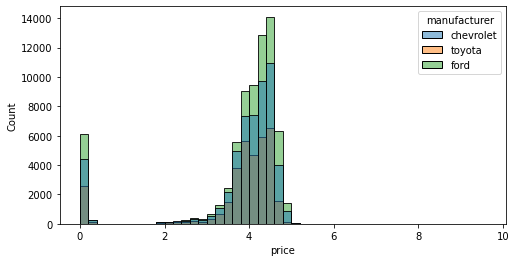

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

_ = sns.histplot(data=df_result, x='price', hue='manufacturer', binwidth=0.2, ax=ax)

plt.show()

## 9.2. Scatter Plot

In [26]:
df_result = spark.sql('SELECT condition, odometer, price FROM cardata')
df_result = df_result.toPandas()

/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


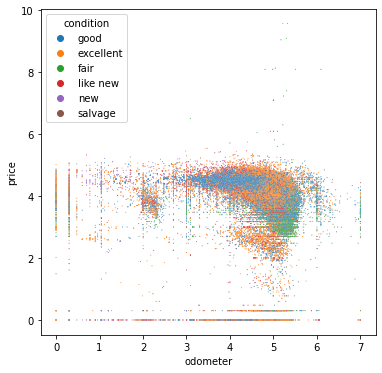

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

_ = sns.scatterplot(data=df_result, x='odometer', y='price', hue='condition', ax=ax, s=1)

plt.show()

## 9.3. Pie Chart

In [28]:
df_result = spark.sql('SELECT condition FROM cardata')
df_result = df_result.toPandas()

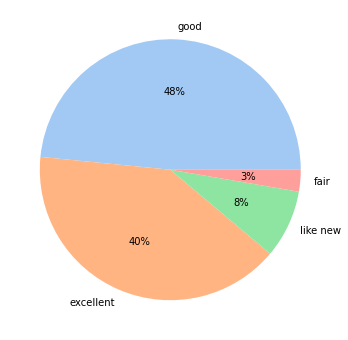

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

data = df_result['condition'].value_counts().nlargest(4)
colors = sns.color_palette('pastel')

plt.pie(data.values, labels=data.index, colors=colors, autopct='%.0f%%')
plt.show()

# 10. Category Dropping


In [30]:
num_cols = ['year', 'odometer', 'lat', 'long', 'posting_year', 'posting_month']

cat_cols = ['region', 'manufacturer', 'model', 'condition', \
            'cylinders', 'fuel', 'title_status', 'transmission',\
           'VIN', 'drive', 'size', 'type', 'paint_color', 'county', 'state']

In [31]:
n = 32

for col in cat_cols:
    most_freq = df_cars.groupBy(col).count().orderBy('count', ascending=False).take(n - 1)
    most_freq = spark.createDataFrame(most_freq).toPandas()
    most_freq = most_freq[col].tolist()

    df_cars = df_cars.withColumn(col, F.when(F.col(col).isin(most_freq), F.col(col)))

# 11. Imputation

## 11.1. On Numeric Columns

In [32]:
imputer = Imputer(inputCols=num_cols, outputCols=num_cols, strategy='mean')
model = imputer.fit(df_cars)
df_cars = model.transform(df_cars)

## 11.2. On Categorical Columns

In [33]:
df_cars = df_cars.fillna('unknown', subset=cat_cols)

# 12. Categorical Column Encoding

In [34]:
for col in cat_cols:
    indexer = StringIndexer(inputCol=col, outputCol=col+'_idx')
    df_cars = indexer.fit(df_cars).transform(df_cars)
    
df_cars = df_cars.drop(*cat_cols)

# 13. Training

In [35]:
cols = df_cars.columns
cols.remove('id')
cols.remove('price')

assembler = VectorAssembler(inputCols=cols, outputCol='features')


df_cars = assembler.transform(df_cars)

In [36]:
df_data = df_cars.select(F.col('features'), F.col('price').alias('label'))
df_train, df_test = df_data.randomSplit([0.8, 0.2])

In [37]:
classifier = RandomForestRegressor(featuresCol='features', labelCol='label')
evaluator = RegressionEvaluator()
grid = ParamGridBuilder().build()

In [38]:
clf = LinearRegression(featuresCol='features', labelCol='label')



In [39]:

clf1 = GBTRegressor(maxDepth=3,featuresCol='features', labelCol='label')

In [40]:
cv = CrossValidator(estimator=classifier, evaluator=evaluator, estimatorParamMaps=grid, numFolds=5)

cv_model = cv.fit(df_train)

In [41]:
cv1 = CrossValidator(estimator=clf, evaluator=evaluator, estimatorParamMaps=grid, numFolds=5)
cv1_model = cv1.fit(df_train)

In [42]:
cv2 = CrossValidator(estimator=clf1, evaluator=evaluator, estimatorParamMaps=grid, numFolds=5)
cv2_model = cv2.fit(df_train)

# 14. Evaluation

In [43]:
df_test1 = cv_model.bestModel.transform(df_test)

In [44]:
df_test2 = cv1_model.bestModel.transform(df_test)

In [45]:
df_test3 = cv2_model.bestModel.transform(df_test)

In [46]:
from pyspark.ml.evaluation import RegressionEvaluator

rmse1 = evaluator.evaluate(df_test1, {evaluator.metricName:'rmse'})
mae1 = evaluator.evaluate(df_test1, {evaluator.metricName:"mae"})
r21 =evaluator.evaluate(df_test1,{evaluator.metricName:'r2'})

rmse2 = evaluator.evaluate(df_test2, {evaluator.metricName:'rmse'})
mae2 = evaluator.evaluate(df_test2, {evaluator.metricName:"mae"})
r22 =evaluator.evaluate(df_test2,{evaluator.metricName:'r2'})

rmse3 = evaluator.evaluate(df_test3, {evaluator.metricName:'rmse'})
mae3 = evaluator.evaluate(df_test3, {evaluator.metricName:"mae"})
r23 =evaluator.evaluate(df_test3,{evaluator.metricName:'r2'})



In [ ]:
print(f"Metrics of Random Forest regressor\nRoot Mean Absolute Error: {rmse1} \nMean Absolute Error: {mae1}\nRsquare: {r21}")

In [ ]:
print(f"Metrics of Linear regressor\nRoot Mean Absolute Error: {rmse2} \nMean Absolute Error: {mae2}\nRsquare: {r22}")

In [ ]:
print(f"Metrics of GBT regressor\nRoot Mean Absolute Error: {rmse3} \nMean Absolute Error: {mae3}\nRsquare: {r23}")

In [ ]:
print(f"Metrics of Generalized linear regressor\nRoot Mean Absolute Error: {rmse3} \nMean Absolute Error: {mae3}\nRsquare: {r23}")

# 15. Single Sample Prediction

In [51]:
X_test, y_test = df_test.head().features, df_test.head().label
y_pred1 = cv_model.bestModel.predict(X_test)
y_pred2 = cv1_model.bestModel.predict(X_test)
y_pred3 = cv2_model.bestModel.predict(X_test)




In [ ]:
print(f'prediction1(Random Forest): {y_pred1}, ground truth: {y_test}\nprediction2(Linear Reg): {y_pred2}, ground truth: {y_test}\nprediction3(GBT): {y_pred3}, ground truth: {y_test}')

16. Comparison of Models (R2 score)



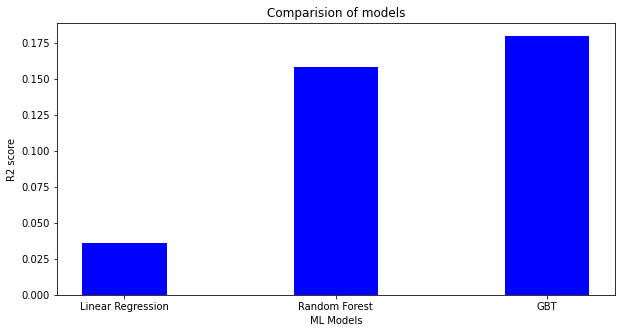

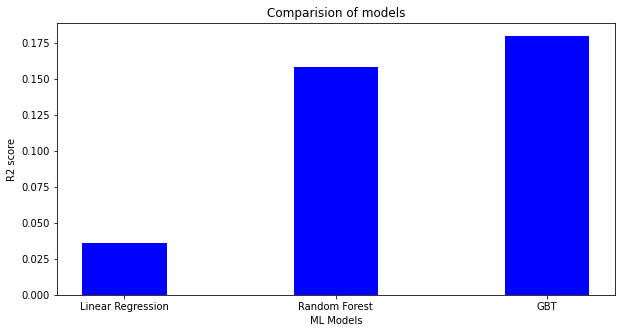

In [53]:
import numpy as np
import matplotlib.pyplot as plt


# creating the dataset
data = {'Linear Regression':0.0357
, 'Random Forest':0.1578, 'GBT':0.1796}
models = list(data.keys())
values = list(data.values())


fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(models, values, color ='blue',
		width = 0.4)

plt.xlabel("ML Models")
plt.ylabel("R2 score")
plt.title("Comparision of models")
plt.show()